# Lab 3

## Reading CSV files

In [1]:
import pandas as pd

training_mice = pd.read_csv('./pw3_data/EEG_mouse_data_1.csv')
training_mice2 = pd.read_csv('./pw3_data/EEG_mouse_data_2.csv')
##testing_mice = pd.read_csv('./pw3_data/EEG_mouse_data_test.csv')

training_data = pd.concat([training_mice, training_mice2], ignore_index=True)


## Choosing features

First idea use ANOVA correlation coefficient for feature selection

In [2]:
from sklearn.feature_selection import f_classif

# feature_list = [
#     "state",
#     "amplitude_around_1_Hertz",
#     "amplitude_around_2_Hertz",
#     "amplitude_around_3_Hertz",
#     "amplitude_around_4_Hertz",
#     "amplitude_around_5_Hertz",
#     "amplitude_around_6_Hertz",
#     "amplitude_around_7_Hertz",
#     "amplitude_around_8_Hertz",
#     "amplitude_around_9_Hertz",
#     "amplitude_around_10_Hertz",
#     "amplitude_around_11_Hertz",
#     "amplitude_around_12_Hertz",
#     "amplitude_around_13_Hertz",
#     "amplitude_around_14_Hertz",
#     "amplitude_around_15_Hertz",
#     "amplitude_around_16_Hertz",
#     "amplitude_around_17_Hertz",
#     "amplitude_around_18_Hertz",
#     "amplitude_around_19_Hertz",
#     "amplitude_around_20_Hertz",
#     "amplitude_around_21_Hertz",
#     "amplitude_around_22_Hertz",
#     "amplitude_around_23_Hertz",
#     "amplitude_around_24_Hertz",
#     "amplitude_around_25_Hertz",
# ]

target = training_data.iloc[:, 0]  # Assuming the first column is the class
features = training_data.iloc[:, 1:]  # Rest of the columns are features

#Calculated the ANOVA correlation coefficient for each feature
anova_corr_coef, _ = f_classif(features, target)
result = pd.DataFrame({'Feature': features.columns, 'anova_coeff': anova_corr_coef})
sorted_result = result.sort_values(by=['anova_coeff'],ascending=False)
first_25 = sorted_result[:25]["Feature"].to_list()
first_25.insert(0, "state")

input_training_mice = training_data[first_25]

print(input_training_mice.head())


  state  amplitude_around_4_Hertz  amplitude_around_3_Hertz  \
0     n                  0.000014                  0.000013   
1     n                  0.000015                  0.000011   
2     n                  0.000019                  0.000034   
3     w                  0.000016                  0.000044   
4     w                  0.000017                  0.000012   

   amplitude_around_2_Hertz  amplitude_around_8_Hertz  \
0                  0.000014                  0.000011   
1                  0.000010                  0.000011   
2                  0.000077                  0.000004   
3                  0.000031                  0.000007   
4                  0.000011                  0.000025   

   amplitude_around_14_Hertz  amplitude_around_15_Hertz  \
0                   0.000003               1.268680e-06   
1                   0.000003               1.077152e-06   
2                   0.000001               1.294509e-06   
3                   0.000002              

## Normalize and encode data

balance data and fit and transform all column except "state"  with StandardScaler

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

scaler = StandardScaler()
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
# Encode the state
state = pd.DataFrame(input_training_mice['state'])
encoder.fit(state)

output_training_mice = encoder.transform(state)
input_training_mice = input_training_mice.drop(columns=['state'])

print(encoder.categories_)
print(output_training_mice)


for column in input_training_mice:
    column_data = input_training_mice[column].to_frame()
    scaler.fit(column_data)
    input_training_mice[column] = scaler.transform(column_data)
    


[array(['n', 'r', 'w'], dtype=object)]
       state_n  state_r  state_w
0          1.0      0.0      0.0
1          1.0      0.0      0.0
2          1.0      0.0      0.0
3          0.0      0.0      1.0
4          0.0      0.0      1.0
...        ...      ...      ...
40858      0.0      0.0      1.0
40859      0.0      0.0      1.0
40860      0.0      0.0      1.0
40861      0.0      0.0      1.0
40862      0.0      0.0      1.0

[40863 rows x 3 columns]


## Create model and fold

In [4]:
import keras
from keras import layers
from sklearn.model_selection import KFold

keras.utils.set_random_seed(123)
kf = KFold(n_splits=3, shuffle=True)

def create_model():
  # 2 inputs
  # 2 hidden nodes
  # 1 output

  mlp = keras.Sequential([
      layers.Input(25),
      layers.Dense(8, activation="relu"), # Try different numbers of hidden neurons here (e.g. 2, 4, 8, 32, 128)
      layers.Dense(3, activation="softmax"), # Three ouput
  ])

  # Experiment with hyperparameters here:
  # momentum: [0, 0.8, 0.9, 0.99]
  # learning_rate: [0.1, 0.01, 0.001, 0.0001]
  mlp.compile(
      optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.99),
      loss="mse",
  )

  return mlp

mlp = create_model()
mlp.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 208       
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
Total params: 235 (940.00 Byte)
Trainable params: 235 (940.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training

Idea 2, SMOTE (Synthetic Minority Over-sampling Technique ) to balance classes observations

In [5]:
import numpy as np
from imblearn.over_sampling import SMOTE
history_list = []
trained_mlp = []
smote = SMOTE()

for i, (train_index, test_index) in enumerate(kf.split(input_training_mice)):
  # We need to create a new model everytime otherwise fit will continue previous training
 
  mlp = create_model()
  x_train, x_test = input_training_mice.iloc[train_index], input_training_mice.iloc[test_index]
  y_train, y_test = np.array(output_training_mice)[train_index],np.array(output_training_mice)[test_index]
  
  x_train, y_train = smote.fit_resample(x_train, y_train)
  
  history = mlp.fit(
      x=x_train, y=y_train,
      validation_data=(x_test, y_test),
      epochs=50
  )

  history_list.append(history)
  trained_mlp.append(mlp)

Epoch 1/50

1523/1523 [==============================] - 15s 8ms/step - loss: 0.1258 - val_loss: 0.0895
Epoch 2/50
1523/1523 [==============================] - 11s 7ms/step - loss: 0.0872 - val_loss: 0.0894
Epoch 3/50
1523/1523 [==============================] - 9s 6ms/step - loss: 0.0851 - val_loss: 0.0896
Epoch 4/50
1523/1523 [==============================] - 11s 7ms/step - loss: 0.0840 - val_loss: 0.0883
Epoch 5/50
1523/1523 [==============================] - 9s 6ms/step - loss: 0.0834 - val_loss: 0.0868
Epoch 6/50
1523/1523 [==============================] - 11s 7ms/step - loss: 0.0829 - val_loss: 0.0877
Epoch 7/50
1523/1523 [==============================] - 11s 7ms/step - loss: 0.0823 - val_loss: 0.0862
Epoch 8/50
1523/1523 [==============================] - 11s 7ms/step - loss: 0.0818 - val_loss: 0.0914
Epoch 9/50
1523/1523 [==============================] - 10s 7ms/step - loss: 0.0814 - val_loss: 0.0870
Epoch 10/50
1523/1523 [==============================] - 9s 6ms/step - los

## Plot training history

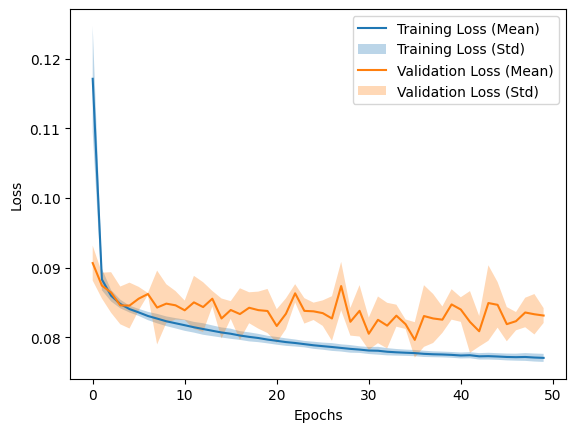

In [6]:
import matplotlib.pyplot as pl
%matplotlib inline

train_losses = np.array([history.history['loss'] for history in history_list])
val_losses = np.array([history.history['val_loss'] for history in history_list])

# Calculate mean and standard deviation for training and validation losses
mean_train_loss = np.mean(train_losses, axis=0)
std_train_loss = np.std(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)
std_val_loss = np.std(val_losses, axis=0)

# Plot mean and standard deviation for training loss
pl.plot(mean_train_loss, label='Training Loss (Mean)')
pl.fill_between(range(len(mean_train_loss)), mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, alpha=0.3, label='Training Loss (Std)')

# Plot mean and standard deviation for validation loss
pl.plot(mean_val_loss, label='Validation Loss (Mean)')
pl.fill_between(range(len(mean_val_loss)), mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.3, label='Validation Loss (Std)')

# Add labels and legend
pl.xlabel('Epochs')
pl.ylabel('Loss')
pl.legend()

# Display the plot
pl.show()

## Performance

426/426 [==============================] - 2s 4ms/step


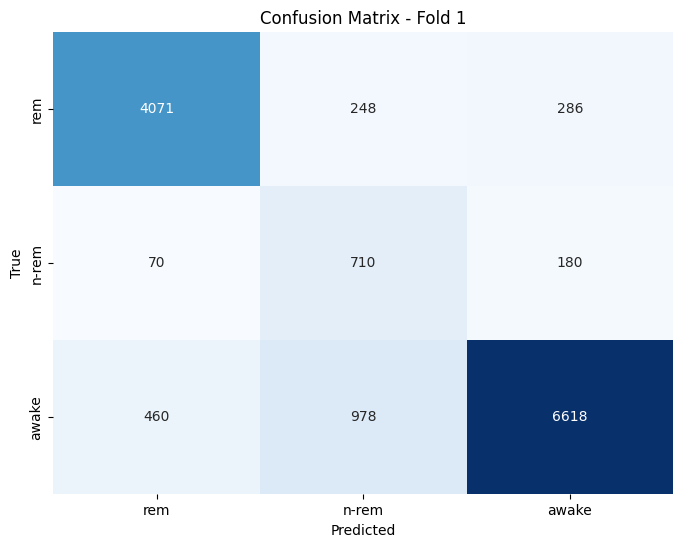

F1 Score - Fold 1: 0.8506253523156342
426/426 [==============================] - 1s 3ms/step


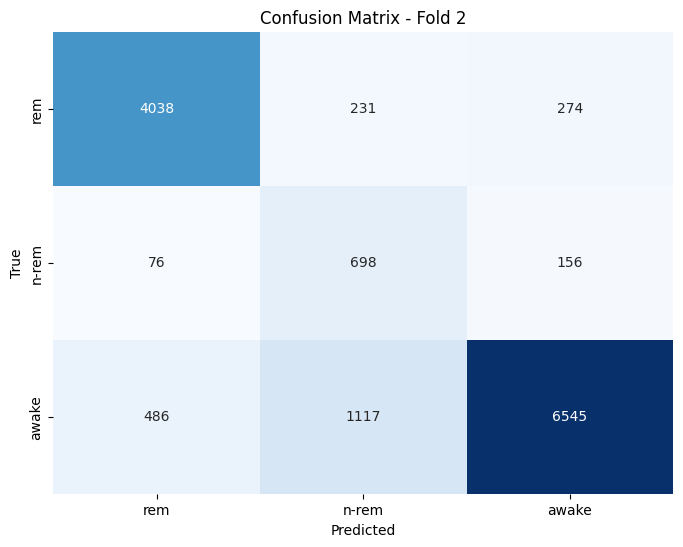

F1 Score - Fold 2: 0.8444117323322896
426/426 [==============================] - 1s 2ms/step


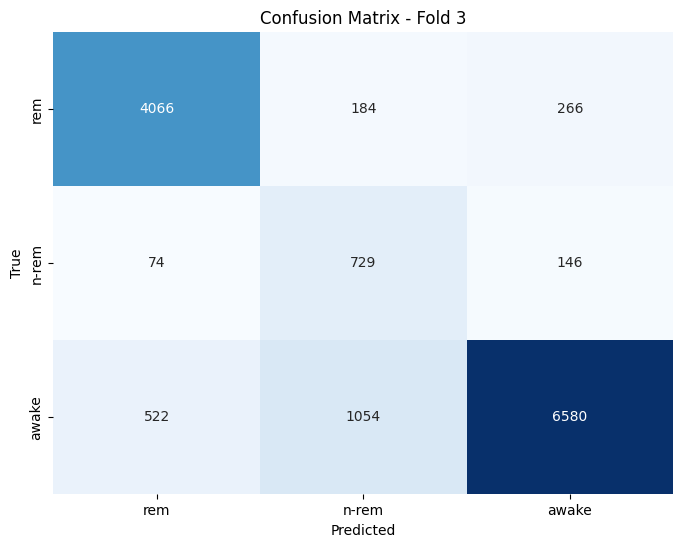

F1 Score - Fold 3: 0.8487951619667821


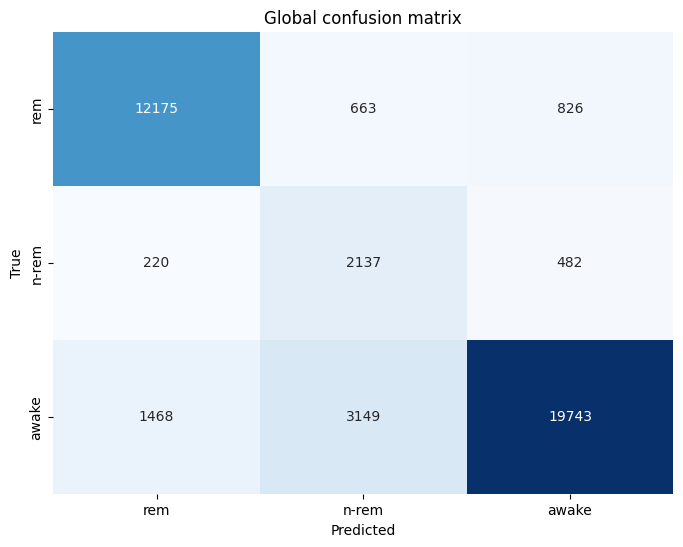

Mean F1 Score across all folds: 0.847944082204902


In [7]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

def plot_confusion_matrix(confusion_matrix, title):
    # Plot confusion matrix
    pl.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix.astype(int), annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["rem","n-rem","awake"], yticklabels=["rem","n-rem", "awake"])
    pl.title(title)
    pl.xlabel('Predicted')
    pl.ylabel('True')
    pl.show()

f1_scores = []
mean_confusion_matrix = np.zeros((3, 3))

for i, (train_index, test_index) in enumerate(kf.split(input_training_mice)):
    # Evaluate the trained model on the test fold
    predictions = trained_mlp[i].predict(input_training_mice.loc[test_index])
    true_labels = np.array(output_training_mice)[test_index]
    
    max_predictions = []
    max_true_labels = []
    for prediction in predictions:
        max_predictions.append(np.argmax(prediction))
        
    for true_label in true_labels:
        max_true_labels.append(np.argmax(true_label))
    
    # Compute confusion matrix
    cm = confusion_matrix(max_true_labels, max_predictions)
    mean_confusion_matrix += confusion_matrix(max_true_labels, max_predictions)

    # Compute confusion matrix and plot
    plot_confusion_matrix(cm, f'Confusion Matrix - Fold {i + 1}')

    # Compute F1 score
    f1 = f1_score(max_true_labels, max_predictions, average='weighted')
    f1_scores.append(f1)
    print(f"F1 Score - Fold {i + 1}: {f1}")

# Plot mean confusion matrix
plot_confusion_matrix(mean_confusion_matrix, 'Global confusion matrix')

# Calculate and display the mean F1 score across all folds
mean_f1_score = np.mean(f1_scores)
print(f"Mean F1 Score across all folds: {mean_f1_score}")

## Résultat

Après avoir encoder les sorties, changer les fonctions d'activations et modifier la matrice de confusion, on a un modèle qui s'en sort très bien pour la classe réveillé et rem, en revanche il a un peu plus de mal avec les n-rem. Sela s'explique par le fait que nous avons seulement 2839 observations.
Une solution pourrait d'augmenter le nombre de données pour avoir un nombre ressemblant aux 2 autres classes
